In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
from sklearn.pipeline import Pipeline
from ff_custom_scripts import *

In [14]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


# Model

In [15]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    categorical_features = cols_per_type(X_train, 'Ordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    ordinal_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(100, 1000),
            'regressor__learning_rate': space.Real(0.01, 0.05),
            'regressor__max_depth': space.Integer(2, 5),
            'regressor__subsample': space.Real(0.4, 0.8),
            'regressor__colsample_bytree': space.Real(0.4, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )
    
    model.fit(X_train, y_train)
    
    return model


# GPA

In [16]:
gpa_model = run_model(train,target='gpa', classifier=False)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [17]:
score_model(gpa_model,'gpa',test,leaderboard,holdout=None,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4061
Standard deviation of CV scores: 0.0401
Mean CV score: 0.4159
Test MSE: 0.3968
Test R2: 0.1227
>> Leaderboard MSE: 0.3845
Leaderboard R2: 0.0158


# Material Hardship

In [18]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [19]:
model_materialHardship.best_params_

OrderedDict([('regressor__colsample_bytree', 0.41221838274599537),
             ('regressor__learning_rate', 0.021130901339300144),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 454),
             ('regressor__subsample', 0.6904807538403688)])

In [20]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.0215
Standard deviation of CV scores: 0.0037
Mean CV score: 0.0220
Test MSE: 0.0199
Test R2: 0.2106
>> Leaderboard MSE: 0.0245
Leaderboard R2: 0.1429


# Grit


In [21]:
model_grit = run_model(train,target='grit', classifier=False)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [22]:
model_grit.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6138721865203991),
             ('regressor__learning_rate', 0.026903038203804172),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 282),
             ('regressor__subsample', 0.7385616673608244)])

In [23]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=None, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2427
Standard deviation of CV scores: 0.0413
Mean CV score: 0.2504
Test MSE: 0.2207
Test R2: 0.0159
>> Leaderboard MSE: 0.2891
Leaderboard R2: -0.3159


# Eviction

In [24]:
model_eviction = run_model(train,target='eviction', classifier=True)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [25]:
model_eviction.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6573580990269696),
             ('regressor__learning_rate', 0.03839797463244792),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 497),
             ('regressor__scale_pos_weight', 8),
             ('regressor__subsample', 0.4089659185057217)])

In [26]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0585
Number of positive predictions: 1
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.9415
Leaderboard Recall: 0.0000


Scores with threshold adjusment


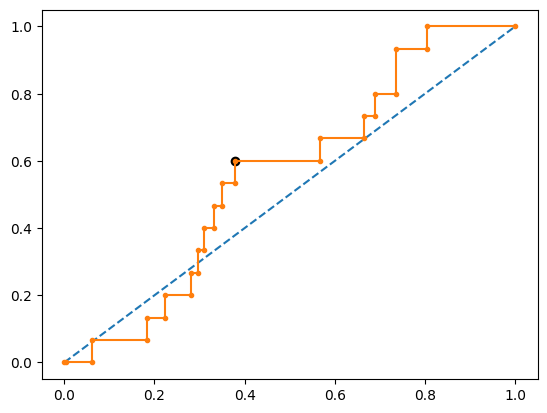

Threshold=0.012, FPR=0.379, TPR=0.600
Test brier: 0.384
Test F1: 0.125
Leaderboard Brier: 0.370
              precision    recall  f1-score   support

         0.0       0.96      0.63      0.76       500
         1.0       0.09      0.57      0.15        30

    accuracy                           0.63       530
   macro avg       0.52      0.60      0.46       530
weighted avg       0.91      0.63      0.73       530

Leaderboard F1: 0.148


In [27]:
score_classifier(model_eviction, 'eviction', test, leaderboard, holdout=None)

# jobTraining

In [28]:
model_job = run_model(train,target='jobTraining', classifier=True)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [29]:
model_job.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6573580990269696),
             ('regressor__learning_rate', 0.03839797463244792),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 497),
             ('regressor__scale_pos_weight', 8),
             ('regressor__subsample', 0.4089659185057217)])

In [30]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.2637
Test F1: 0.3636
Leaderboard Brier: 0.3057
Number of positive predictions: 69
>> Leaderboard F1: 0.2500
Leaderboard Accuracy: 0.6943
Leaderboard Recall: 0.1837


Scores with threshold adjusment


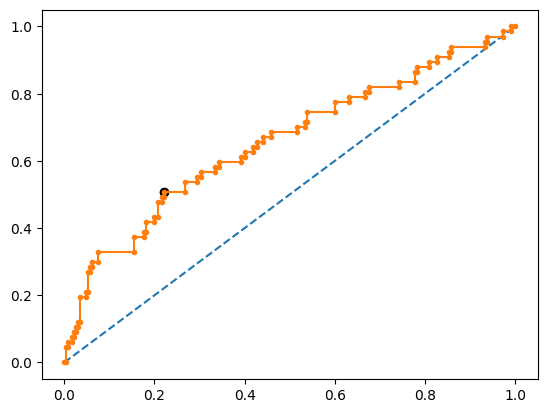

Threshold=0.390, FPR=0.222, TPR=0.507
Test brier: 0.288
Test F1: 0.440
Leaderboard Brier: 0.328
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.79       383
         1.0       0.37      0.25      0.30       147

    accuracy                           0.67       530
   macro avg       0.55      0.54      0.54       530
weighted avg       0.64      0.67      0.65       530

Leaderboard F1: 0.298


In [37]:
score_classifier(model_job, 'jobTraining', test, leaderboard, holdout=None)

# Layoff

In [32]:
model_layoff = run_model(train, target='layoff', classifier=True)

N. of numerical features: 106
N. of categorical features: 414
N. of binary features: 570
N. of ordinal features: 114


In [33]:
model_layoff.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6573580990269696),
             ('regressor__learning_rate', 0.03839797463244792),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 497),
             ('regressor__scale_pos_weight', 8),
             ('regressor__subsample', 0.4089659185057217)])

In [34]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout=None, classifier=True)

Scores without threshold adjusment
Test Brier: 0.2231
Test F1: 0.1515
Leaderboard Brier: 0.2453
Number of positive predictions: 31
>> Leaderboard F1: 0.1333
Leaderboard Accuracy: 0.7547
Leaderboard Recall: 0.0840


Scores with threshold adjusment


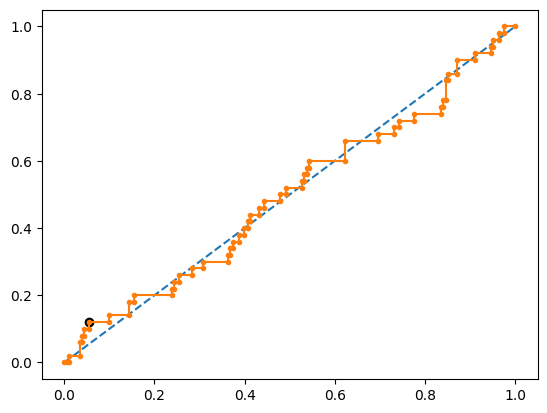

Threshold=0.500, FPR=0.055, TPR=0.120
Test brier: 0.223
Test F1: 0.152
Leaderboard Brier: 0.245
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       411
         1.0       0.32      0.08      0.13       119

    accuracy                           0.75       530
   macro avg       0.55      0.52      0.50       530
weighted avg       0.68      0.75      0.69       530

Leaderboard F1: 0.133


In [35]:
score_classifier(model_layoff, 'layoff', test, leaderboard, holdout=None)